<a href="https://colab.research.google.com/github/Kiran98780/NLP_Assignment2/blob/main/(Unsorted_88_percent_acc)Copy_of_Copy_of_Replies_Copy_of_BERT_for_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Mount drive
Mount your google drive which has the training, test and dev jsonlfiles and labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/NLP_data

/content/drive/My Drive/NLP_data


In [ ]:
%ls

'Copy_of_10_bert (1).ipynb'   sstcls_0.dat                 test.data.jsonl
 dev.baseline_03_BERT.json    sstcls_1.dat                 train.data.jsonl
 dev.data.jsonl               sstcls_2.dat                 train.label.json
 dev.label.json               sstcls_4.dat
 model_save/                  test.baseline_03_BERT.json


In [ ]:
%cd /content/drive/My Drive/NLP_data

/content/drive/My Drive/NLP_data


In [ ]:
%ls

'Copy_of_10_bert (1).ipynb'   sstcls_0.dat                 test.data.jsonl
 dev.baseline_03_BERT.json    sstcls_1.dat                 train.data.jsonl
 dev.data.jsonl               sstcls_2.dat                 train.label.json
 dev.label.json               sstcls_4.dat
 model_save/                  test.baseline_03_BERT.json


# Step 2 - Setup

## 1. Load Essential Libraries

In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import collections
import json
from sklearn import preprocessing

%matplotlib inline

## 2. Dataset

In [ ]:
#function to return the replies as a list for a source tweet 
def get_replies(df):
    dict_time = {}
    for index, row in df.iterrows():
        replyTw_list = []
        #check if the in_reply_to_status_id_str string matches a number
        x = re.search(r'\d+', str(row['in_reply_to_status_id_str']))  
        if x:
            #append the reply tweets in a big_list and return the list
            big_list.append(row["tweet"]) 
            replyTw_list.append(row["tweet"])
            #if the tweets are created at the same time - append it to existing list
            if (row["created_at"] in dict_time):
                replyTw_list.append(row["tweet"])
            dict_time[row["created_at"]] = replyTw_list
        else:
            big_list = []
    #returns the list of replies for a source tweet, length of the reply list and dict of {created_at_Time:reply_tweet}
    return big_list,len(big_list),dict_time 

#function to return the list of reply tweets sorted by time for all source tweets
#takes the list of dictionaries as a parameter of the form [{created_At_time1:[tweet1, tweet2]},{created_At_time2:[tweet3]}]
def get_sorted_by_time(dict_replies_list):
    sorted_list = []
    for i in range(len(dict_replies_list)):
        # dtime = 'Mon Dec 15 21:50:30 +0000 2014'
        newkeys_list = []
        for k, v in dict_replies_list[i].items():  
            new_datetime = datetime.strftime(datetime.strptime(k,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S') 
            date_to_float = datetime.fromisoformat(new_datetime).timestamp()#1420646211.0
            newkeys_list.append(date_to_float) #list of keys for the new dictionary 
            vals = list(dict_replies_list[i].values()) #list of values for the new dictionary 
        newdictionary = {k: v for k, v in zip(newkeys_list, vals)} #zip the keys and values to form a new dictionary 
        sorted_list.append(newdictionary)
    print("The length of sorted list is = ", len(sorted_list))
    return sorted_list

### 2.1. Load Train Data
The train.data.jsonl has about 4k source tweets and about 81k source + reply tweets.

The label files ([train,dev].label.json), are standard JSON files:
{
"552800070199148544": "non-rumour",
"544388259359387648": "non-rumour",
"552805970536333314": "non-rumour",
"525071376084791297": "rumour"
} 

All data files ([train,dev,test,covid].data.jsonl) are JSONL files, where each line is a JSON string. For these files, each line is an event: a list of tweets where the first tweet is a source tweet and the rest are reply tweets.

Here the train data is loaded and merged with the labels and the resulting columns are "id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at", "label"].

In [ ]:
# pd.set_option('display.width', 1000)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.min_rows', 100)
# pd.set_option('display.max_rows', 500)
# def load_data(data_filename, label_filename):
#     with open(data_filename, 'r', encoding='utf-8') as train_data_file:
#       list_of_rlists = []
#       chunks = [] #list of all the dataframes for all source and reply tweets
#       num_replies = [] #list of number of replies for every source tweet 
#       dict_replies= {} #dict of {created_At_time:[reply tweet]} for every source tweet
#       list_replies = []
#       dict_replies_list = []
#       for line in train_data_file:
#         train_Data_list = json.loads(line)
#         df = pd.DataFrame.from_dict(train_Data_list)
#         df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
#         df.rename(columns={'id_str': 'id'}, inplace=True)
#         df.rename(columns={'text': 'tweet'}, inplace=True)

#         replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
#         replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
#         # print(len(replies_list_2d))
#         replies_list_1d = [j for sub in replies_list_2d for j in sub]
#         # print(len(replies_list_1d))
#         reply_length = len(replies_list_1d)
#         list_replies.append(reply_length) 
#         dict_replies_list.append(dict_replies)

#         chunks.append(df)
#         list_of_rlists.append(replies_list)
#         num_replies.append(len_reply_list)
#         # print("The output of list_of_rlists in every iteration=",list_of_rlists,"\n",len(list_of_rlists))
#       dfs1 = pd.concat(chunks)
#     train_data_file.close()
#     #print(dfs1)
#     print("The len of list of list of replies=", len(list_of_rlists))


#     with open(label_filename) as train_label_file:
#         train_label_json_file = json.load(train_label_file)
#         df_train_label = pd.DataFrame(list(train_label_json_file.items()),columns = ['id', 'label'])
#     train_label_file.close()

#     #check for class imbalance
#     print(df_train_label)
#     print(df_train_label.groupby('label').size())
#     # non - rumour
#     # 3058
#     # rumour
#     # 1583a

#     #check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
#     df_final1 = pd.merge(dfs1, df_train_label, how='left', left_on='id', right_on='id')
#     df_final2 = pd.merge(dfs1, df_train_label, how='inner', left_on='id', right_on='id')

#     # print(df_final1)
#     print(df_final1.shape) #(81120, 7)

#     # print(df_final2)
#     print(df_final2.shape) #(4641, 7)


#     #only text and label - drop columns from old one and store in new one 
#     Corpus = df_final2.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
#     le = preprocessing.LabelEncoder()

#     reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
#     sorted_replies = []
#     for i in range(len(reply_dict_list)):
#       values_2d = reply_dict_list[i].values()
#       values_list_1d = [j for sub in values_2d for j in sub ]
#       sorted_replies.append(values_list_1d)

#     Corpus['label'] = le.fit_transform(Corpus['label'])
#     Corpus["all_replies"] = list_of_rlists #has a list of replies 
#     Corpus["num_replies"] = num_replies
#     Corpus["dict_replies"] = list_replies
#     Corpus["all_replies_by_time"] = sorted_replies
#     print(Corpus.head(10))
#     print(Corpus.dtypes)
#     print(Corpus.shape)

#     return Corpus


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The len of list of list of replies= 4641
(81120, 8)
(4641, 8)


# Check for class imbalance

In [ ]:
# Corpus = load_data("train.data.jsonl","train.label.json")
# Corpus_dev = load_data("dev.data.jsonl","dev.label.json")

In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 500)
with open(data_filename, 'r', encoding='utf-8') as train_data_file:
  list_of_rlists = []
  chunks = [] #list of all the dataframes for all source and reply tweets
  num_replies = [] #list of number of replies for every source tweet 
  dict_replies= {} #dict of {created_At_time:[reply tweet]} for every source tweet
  list_replies = []
  dict_replies_list = []
  for line in train_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)

    replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
    replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
    # print(len(replies_list_2d))
    replies_list_1d = [j for sub in replies_list_2d for j in sub]
    # print(len(replies_list_1d))
    reply_length = len(replies_list_1d)
    list_replies.append(reply_length) 
    dict_replies_list.append(dict_replies)

    chunks.append(df)
    list_of_rlists.append(replies_list)
    num_replies.append(len_reply_list)
    # print("The output of list_of_rlists in every iteration=",list_of_rlists,"\n",len(list_of_rlists))
  dfs1 = pd.concat(chunks)
train_data_file.close()
#print(dfs1)
print("The len of list of list of replies=", len(list_of_rlists))


with open(label_filename) as train_label_file:
    train_label_json_file = json.load(train_label_file)
    df_train_label = pd.DataFrame(list(train_label_json_file.items()),columns = ['id', 'label'])
train_label_file.close()

#check for class imbalance
print(df_train_label)
print(df_train_label.groupby('label').size())
# non - rumour
# 3058
# rumour
# 1583a

#check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
df_final1 = pd.merge(dfs1, df_train_label, how='left', left_on='id', right_on='id')
df_final2 = pd.merge(dfs1, df_train_label, how='inner', left_on='id', right_on='id')

# print(df_final1)
print(df_final1.shape) #(81120, 7)

# print(df_final2)
print(df_final2.shape) #(4641, 7)


#only text and label - drop columns from old one and store in new one 
Corpus = df_final2.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
le = preprocessing.LabelEncoder()

reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
sorted_replies = []
for i in range(len(reply_dict_list)):
  values_2d = reply_dict_list[i].values()
  values_list_1d = [j for sub in values_2d for j in sub ]
  sorted_replies.append(values_list_1d)

Corpus['label'] = le.fit_transform(Corpus['label'])
Corpus["all_replies"] = list_of_rlists #has a list of replies 
Corpus["num_replies"] = num_replies
Corpus["dict_replies"] = list_replies
Corpus["all_replies_by_time"] = sorted_replies
print(Corpus.head(10))
print(Corpus.dtypes)
print(Corpus.shape)

return Corpus


In [ ]:
diff =Corpus[Corpus.num_replies != Corpus.dict_replies]
print(len(diff))
diff
print(diff)

11
                      id                                              tweet                      created_at  label                                        all_replies  num_replies  dict_replies                                all_replies_by_time
23    544286688436969472  thinking of the people in Martin Place in Sydn...  Mon Dec 15 00:23:53 +0000 2014      0  [@canwejustzalfie @youtubings @pointlesszoeee ...          133           130  [@canwejustzalfie @youtubings @pointlesszoeee ...
166   544346359948910592  Hearing about the hostage situation in Sydney,...  Mon Dec 15 04:21:00 +0000 2014      1  [@Ashton5SOS everything is gonna be fine 💪, @t...           27            21  [@Ashton5SOS everything is gonna be fine 💪, @t...
862   544480083982168064  Sending all my love to Sydney. Horrible situat...  Mon Dec 15 13:12:22 +0000 2014      0  [@haleighsmithhh @AlexAllTimeLow there was a a...           24            23  [@haleighsmithhh @AlexAllTimeLow there was a a...
1024  553546063752478

In [ ]:
# with open("dev.data.jsonl", 'r', encoding='utf-8') as dev_data_file:
#   list_of_rlists = []
#   chunks = []
#   num_replies = []
#   dict_replies= {}
#   list_replies = []
#   dict_replies_list = []
#   for line in dev_data_file:
#     dev_Data_list = json.loads(line)
#     df = pd.DataFrame.from_dict(dev_Data_list)
#     df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
#     df.rename(columns={'id_str': 'id'}, inplace=True)
#     df.rename(columns={'text': 'tweet'}, inplace=True)

#     # replies_list,len_reply_list = get_replies(df)
#     replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
#     replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
#     # print(len(replies_list_2d))
#     replies_list_1d = [j for sub in replies_list_2d for j in sub]
#     # print(len(replies_list_1d))
#     reply_length = len(replies_list_1d)
#     list_replies.append(reply_length) 
#     dict_replies_list.append(dict_replies)

#     chunks.append(df)
#     num_replies.append(len_reply_list)
#     list_of_rlists.append(replies_list)
#   dfs_dev = pd.concat(chunks)
# dev_data_file.close()
# #print(dfs_dev)

# with open("dev.label.json") as dev_label_file:
#     dev_label_json_file = json.load(dev_label_file)
#     df_dev_label = pd.DataFrame(list(dev_label_json_file.items()),columns = ['id', 'label'])
# dev_label_file.close()

# #print(df_train_label)
# #print(df_train_label.groupby('label').size())
# # non - rumour
# # 3058
# # rumour
# # 1583

# #check the id and if it is present in rumours/non-rumours labels, then add it to the row of that dataframe (check from the labels dataframe)
# df_final1_dev = pd.merge(dfs_dev, df_dev_label, how='left', left_on='id', right_on='id')
# df_final2_dev = pd.merge(dfs_dev, df_dev_label, how='inner', left_on='id', right_on='id')

# # print(df_final1_dev)
# print(df_final1_dev.shape)
# # print(df_final2_dev)
# print(df_final2_dev.shape)

# reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
# sorted_replies = []
# for i in range(len(reply_dict_list)):
#   values_2d = reply_dict_list[i].values()
#   values_list_1d = [j for sub in values_2d for j in sub ]
#   sorted_replies.append(values_list_1d)

# #only text and label - drop columns from old one and store in new one 
# Corpus_dev = df_final2_dev.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
# le = preprocessing.LabelEncoder()
# Corpus_dev['label'] = le.fit_transform(Corpus_dev['label'])
# Corpus_dev["all_replies"] = list_of_rlists #has a list of replies 
# Corpus_dev["num_replies"] = num_replies
# Corpus_dev["all_replies_by_time"] = sorted_replies

# print(Corpus_dev.head(10))
# print(Corpus_dev.shape)
# print(Corpus_dev.dtypes)


(10546, 8)
(580, 8)
The length of sorted list is =  580
                   id                                              tweet                      created_at  label                                        all_replies  num_replies                                all_replies_by_time
0  553588913747808256  #BREAKING Reports: 2 brothers suspected of Cha...  Fri Jan 09 16:27:36 +0000 2015      1  [@USATODAY :it's unfortunate that they got wha...           10  [@USATODAY :it's unfortunate that they got wha...
1  524949003834634240  You are not alone today #Ottawa - we are here ...  Wed Oct 22 15:42:50 +0000 2014      0  [@DistressCentreO @CFRASnow interestingly - I'...            1  [@DistressCentreO @CFRASnow interestingly - I'...
2  553221281181859841  Have said it before, but needs saying again: S...  Thu Jan 08 16:06:46 +0000 2015      0  [@kevinkrease @Max_Fisher That's a ludicrous s...           34  [@kevinkrease @Max_Fisher That's a ludicrous s...
3  580322346508124160  Germanwings #

In [ ]:
with open("test.data.jsonl", 'r', encoding='utf-8') as test_data_file:
  list_of_rlists = []
  chunks = []
  num_replies = []
  dict_replies= {}
  list_replies = []
  dict_replies_list = []

  for line in test_data_file:
    train_Data_list = json.loads(line)
    df = pd.DataFrame.from_dict(train_Data_list)
    df = df[["id_str","in_reply_to_status_id_str","text", "user","favorited","in_reply_to_user_id_str","created_at"]]
    df.rename(columns={'id_str': 'id'}, inplace=True)
    df.rename(columns={'text': 'tweet'}, inplace=True)
    # replies_list,len_reply_list = get_replies(df)
    
    # replies_list,len_reply_list = get_replies(df)
    replies_list,len_reply_list,dict_replies = get_replies(df) #reply list for a single source tweet
    replies_list_2d = list(dict_replies.values()) #get all the replies for a single source tweet
    # print(len(replies_list_2d))
    replies_list_1d = [j for sub in replies_list_2d for j in sub]
    # print(len(replies_list_1d))
    reply_length = len(replies_list_1d)
    list_replies.append(reply_length) 
    dict_replies_list.append(dict_replies)

    chunks.append(df)
    num_replies.append(len_reply_list)
    list_of_rlists.append(replies_list)
  dfs1 = pd.concat(chunks)
test_data_file.close()
#print(dfs1)
finalll = dfs1[dfs1['in_reply_to_status_id_str'].isna()] #source tweets
# print(finalll)

# print(dfs1["in_reply_to_status_id_str"].isnull().sum())
# c=0
# if (dfs1["in_reply_to_status_id_str"].isnull()).all():
#     c = c+1
# print(c)
# cli = np.where(dfs1["in_reply_to_status_id_str"].isnull())
# print(cli)
reply_dict_list = get_sorted_by_time(dict_replies_list) #list of dicts 
sorted_replies = []
for i in range(len(reply_dict_list)):
  values_2d = reply_dict_list[i].values()
  values_list_1d = [j for sub in values_2d for j in sub ]
  sorted_replies.append(values_list_1d)

#only text - drop columns from old one and store in new one 
Corpus_test = finalll.drop(["in_reply_to_status_id_str","user","favorited","in_reply_to_user_id_str"], axis=1)
Corpus_test["all_replies"] = list_of_rlists #has a list of replies 
Corpus_test["num_replies"] = num_replies
Corpus_test["all_replies_by_time"] = sorted_replies

print(Corpus_test.head(10))
print(Corpus_test.shape)
print(Corpus_test.dtypes)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The length of sorted list is =  581
                   id                                              tweet                      created_at                                        all_replies  num_replies                                all_replies_by_time
0  544382249178001408  5 people have been able to get out of Sydney c...  Mon Dec 15 06:43:36 +0000 2014  [@ABC @SSLATERBOARDS fucking terrorists, @ABC ...           16  [@ABC @SSLATERBOARDS fucking terrorists, @ABC ...
0  525027317551079424  NEW: Sources: Deceased gunman who killed soldi...  Wed Oct 22 20:54:01 +0000 2014  [@albanyly @ABC @theviewtv @WorldNews piss off...           11  [@albanyly @ABC @theviewtv @WorldNews piss off...
0  544273220128739329  ISIS FLAG VISIBLE AS GUNMAN SEIZES SYDNEY CAFE...  Sun Dec 14 23:30:22 +0000 2014  [@rConflictNews @PzFeed Its not ISIS flag its ...           39  [@rConflictNews @PzFeed Its not ISIS flag its ...
0  499571799764770816  People of #Ferguson: Stop #attacking our brave...  Wed Aug 13

We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [ ]:
replies_train = [' [SEP] '.join([str(tweet) for tweet in all_replies]) for all_replies in Corpus.all_replies_by_time.values]
replies_dev = ['[SEP] '.join([str(tweet) for tweet in all_replies]) for all_replies in Corpus_dev.all_replies_by_time.values]
replies_test = ['[SEP] '.join([str(tweet) for tweet in all_replies]) for all_replies in Corpus_test.all_replies_by_time.values]
# X = Corpus.tweet.values 
X = Corpus.tweet.values + replies_train
y = Corpus.label.values
# print(Corpus.all_replies.values)

# print(len(replies))
# count=0
# for i in Corpus.all_replies.values:
#   # print(' '.join([str(elem) for elem in i]))
#   list_to_str_reply = ' '.join([str(elem) for elem in i])
#   count = count + 1
# print(count, len(list_to_str_reply)) #4641
# X_train = Corpus.tweet.values
# X_val = Corpus_dev.tweet.values 
# input = f"[CLS] {Source_tweet} [SEP] " + ''.join([f"{reply} [SEP]" for reply in all_replies])

X_train = list(zip(Corpus.tweet.values, replies_train))
# X_train = Corpus.tweet.values + replies_train
X_val = list(zip(Corpus_dev.tweet.values, replies_dev))
y_train = Corpus.label.values
y_val = Corpus_dev.label.values
X_test = list(zip(Corpus_test.tweet.values + replies_test))
print(len(X_train),len(X_val),len(X_test))
print(type(X_train))
for i in range(10):
  print(X_train[i],"\n")

4641 580 581
<class 'list'>
('How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j', "@Heresy_Corner @KrustyAllslopp \nJews label anyone they don't like as Anti-Semite and campaign until that person/company is finished. [SEP] @Heresy_Corner @KrustyAllslopp \nNo one does. [SEP] @Heresy_Corner #ImCharlieHebdo [SEP] @KrustyAllslopp Ditto [SEP] @Grizzly_Stats @tom_wein What innocent Muslims ought to find insulting is an atrocity committed in their name, not a sodding cartoon. [SEP] @Heresy_Corner @KrustyAllslopp \nYes, until it becomes yours. [SEP] @Heresy_Corner @KrustyAllslopp \nWhy insult people who have nothing to do with this? People are genuinely offended by such drawings. [SEP] @KrustyAllslopp @Heresy_Corner \nAnd neither am I! I think this has little to do with actual Muslims. [SEP] @berg_han Ah, you don't like Jews. Bye bye. @KrustyAllslopp [SEP] @Heresy_Corner Also they kid you along with benign stuff

In [ ]:
print(X_train,y_train)

### 2.3. Load Test Data
The test data contains 4555 examples with no label. About 300 examples are non-complaining tweets. Our task is to identify their `id` and examine manually whether our results are correct.

In [ ]:
# Load test data
test_data = Corpus_test
# Display 5 samples from the test data
test_data.sample(5)

,id,tweet,created_at,all_replies,num_replies,all_replies_by_time
0,552825473160736768,"As a Muslim, I strongly condemn this brutal te...",Wed Jan 07 13:53:58 +0000 2015,[@SonVesayet @gulkork22 you don't need to be m...,1,[@SonVesayet @gulkork22 you don't need to be m...
0,580347361039413248,Airline #Germanwings says 144 passengers and s...,Tue Mar 24 12:36:07 +0000 2015,[],0,[]
0,499703651079045121,This. RT @grasswire: State Senator asks the #F...,Wed Aug 13 23:46:49 +0000 2014,[],0,[]
0,524979179235069952,Remembrance Day ceremony in Ottawa is emotiona...,Wed Oct 22 17:42:44 +0000 2014,"[@fs1otoole if they won't be all there, the en...",13,"[@fs1otoole if they won't be all there, the en..."
0,524966596897685504,Stunning photos from Ottawa http://t.co/xQTgZ8...,Wed Oct 22 16:52:44 +0000 2014,"[@HuffPostCanada so sorry they now have ""work...",7,"[@HuffPostCanada so sorry they now have ""work..."


## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

A GPU can be added by going to the menu and selecting:

`Runtime -> Change runtime type -> Hardware accelerator: GPU`

Then we need to run the following cell to specify the GPU as the device.

In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla K80


# C - Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

Why Naive Bayse? I have experiemented different machine learning algorithms including Random Forest, Support Vectors Machine, XGBoost and observed that Naive Bayes yields the best performance. In [Scikit-learn's guide](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) to choose the right estimator, it is also suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

## 1. Data Preparation

### 1.1. Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

### 1.2. TF-IDF Vectorizer

In information retrieval, **TF-IDF**, short for **term frequency–inverse document frequency**, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])
X_test_preprocessed = np.array([text_preprocessing(text) for text in X_test])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False) #initialise vectorisor
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)
X_test_tfidf = tf_idf.transform(X_test_preprocessed)

In [ ]:
# print(tf_idf.get_feature_names())
print(X_train_tfidf.shape)
print(X_val_tfidf.shape)
print(X_test_tfidf.shape)
# print(X_val_tfidf)
print("Sparse Matrix form of test data : \n")
X_val_tfidf.todense()

## 2. Train Naive Bayes Classifier

### 2.1. Hyperparameter Tuning

We will use cross-validation and AUC score to tune hyperparameters of our model. The function `get_auc_CV` will return the average AUC score from cross-validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The `MultinominalNB` class only have one hypterparameter - **alpha**. The code below will help us find the alpha value that gives us the highest CV AUC score.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### 2.2. Evaluation on Validation Set

To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    # print("preds", preds)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    # print(fpr, tpr, threshold)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of **72.65%** on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model. 

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
#Predict the response for test dataset
probs = nb_model.predict_proba(X_val_tfidf)
print("PROBS=",probs)
pred = nb_model.predict(X_val_tfidf)
print(pred)
# Evaluate the classifier
evaluate_roc(probs, y_val)

In [ ]:
pred = nb_model.predict(X_test_tfidf)
print(pred)

In [ ]:
y_predicted = nb_model.predict(X_test_tfidf)
y_predicted_labels = le.inverse_transform(y_predicted) 
print(y_predicted,y_predicted_labels)

In [ ]:
y_predicted = nb_model.predict(X_val_tfidf)
y_predicted_labels = le.inverse_transform(y_predicted) 
# print(y_predicted,y_predicted_labels)
print(len(y_predicted_labels))
unique, counts = np.unique(y_predicted, return_counts=True)
dict(zip(unique, counts))

In [ ]:
print(df_dev_label.groupby('label').size())

fig, ax = plt.subplots()
fig.suptitle("label", fontsize=12)
Corpus_dev["label"].reset_index().groupby("label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
Corpus_pred = Corpus_dev
print(Corpus_pred.head())
Corpus_pred['label'] = y_predicted_labels
print(Corpus_pred.head())
Corpus_pred.set_index('id',inplace=True)
dictt = Corpus_pred.to_dict()['label']
print(dictt)
with open("dev.baseline1.json", "w") as outfile: 
    json.dump(dictt, outfile)

In [ ]:
print(Corpus_pred.shape)


# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [ ]:
!pip install transformers==2.8.0

## 2. Tokenization and Input Formatting

Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text_ = [re.sub(r'(@.*?)[\s]', ' ', i) for i in text]

    # Replace '&amp;' with '&'
    text_ = [re.sub(r'&amp;', '&', i) for i in text_]

    # Remove trailing whitespace
    text_ = [re.sub(r'\s+', ' ', i).strip() for i in text_]
    text_ = ' [CLS] ' + text_[0]+ ' [SEP] ' + text_[1] + ' [SEP] '
    return text_

In [ ]:
# Print sentence 0
print('Original: ', X_train[1])
# for i in range(10):
#     print(X_train[i])
print('Processed: ', text_preprocessing(X_train[0]))

Original:  ("You can't condemn an entire race, nation or religion based on the actions of a few radicals, please keep that in mind #sydneysiege", '@LozzaCopland How many times are we going to have the "Don\'t judge Islam by this act of terrorism" conversation? #sydneysiege [SEP] @LozzaCopland indeed not a question of Race or nation. It is this religion og Islam that creates Zombies. [SEP] @LozzaCopland Only very few people can maintain the perspective that you have in this hour of crisis. [SEP] @LozzaCopland .....forthcoming from ppl when all Christians are branded as pedophiles or "just after your money" etc. But apparently in.... [SEP] @LozzaCopland at the response to child sex abuse cases, and ppl slamming Hillsong etc. A full throated defence for these is not often..... [SEP] @LozzaCopland How odd its not an athiest holding hostages? I condemn all religious nuts for as long as they cause pain and suffering... [SEP] @LozzaCopland love the first 4 words in your bio 🙈🙉🙊 [SEP] .@lozzac

### 2.1. BERT Tokenizer

In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The `encode_plus` method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special `[CLS]` and `[SEP]` tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.






In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
      
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
#         Set MAX_LEN = 512

# Pad input_structure to MAX_LEN
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.







In [ ]:
# # Concatenate train data and test data
# all_tweets = np.concatenate([Corpus.tweet.values, test_data.tweet.values])
# print(all_tweets)
# print(type(all_tweets))
# # Encode our concatenated data
# encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
# print(encoded_tweets)
# # Find the maximum length
# max_len = max([len(sent) for sent in encoded_tweets])
# print('Max length: ', max_len)

Now let's tokenize our data.

In [ ]:
# Specify `MAX_LEN`
# MAX_LEN = 64
MAX_LEN = 512

# Print sentence 0 and its encoded token ids
# token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
# print('Original: ', X[0])
# print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
# print(X_train, type(X_train), len(X_train))
# print(X_val, type(X_val), len(X_val))

train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
print(train_inputs, train_masks, val_inputs, val_masks)


Tokenizing data...
tensor([[  101,   101,  2129,  ...,  2123,  1005,   102],
        [  101,   101,  2017,  ...,  7395,  2000,   102],
        [  101,   101,  4740,  ...,     0,     0,     0],
        ...,
        [  101,   101,  9499,  ...,     0,     0,     0],
        [  101,   101,  1999,  ...,     0,     0,     0],
        [  101,   101, 12583,  ...,     0,     0,     0]]) tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]) tensor([[  101,   101,  1001,  ...,     0,     0,     0],
        [  101,   101,  2017,  ...,     0,     0,     0],
        [  101,   101,  2031,  ...,  2017,  2123,   102],
        ...,
        [  101,   101,  2057,  ...,  2288,  2083,   102],
        [  101,   101,  2197,  ...,  1012,  1012,   102],
        [  101,   101, 13970,  ...,     0,     0,     0]]) tensor([[1, 1, 1,  ..., 0, 0, 0],
     

### 2.2. Create PyTorch DataLoader

We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)

Corpus_dev['label'] = le.fit_transform(Corpus_dev['label'])
y_val=Corpus_dev.label.values
print(type(y_val))
print(y_val)
print(Corpus_dev.dtypes)
print(Corpus_dev.head())
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 10

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
print(train_data,train_sampler,train_dataloader)
# Create the DataLoader for our validation set

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

<class 'numpy.ndarray'>
[1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 0 1
 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0
 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 1
 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1
 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0
 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0
 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1
 

## 3. Train Our Model

### 3.1. Create BertClassifier

BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the `[CLS]` token is used as the features of the sequence to feed a classifier.

The `transformers` library has the [`BertForSequenceClassification`](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification) class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the `[CLS]` token and a single-hidden-layer feed-forward neural network as our classifier.

In [ ]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 55.6 µs


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (`loss.backward()`)
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (`optimizer.step()`)
- Update the learning rate (`scheduler.step()`)

Evaluation:
- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop. 

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
  import torch,gc 
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

Now, let's start training our BertClassifier!

In [ ]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


   1    |   20    |   0.672575   |     -      |     -     |   37.10  
   1    |   40    |   0.549966   |     -      |     -     |   35.61  
   1    |   60    |   0.510329   |     -      |     -     |   35.74  
   1    |   80    |   0.463734   |     -      |     -     |   35.94  
   1    |   100   |   0.364506   |     -      |     -     |   35.97  
   1    |   120   |   0.485028   |     -      |     -     |   35.85  
   1    |   140   |   0.516070   |     -      |     -     |   35.93  
   1    |   160   |   0.465323   |     -      |     -     |   35.95  
   1    |   180   |   0.564190   |     -      |     -     |   35.96  
   1    |   200   |   0.455357   |     -      |     -     |   35.88  
   1    |   220   |   0.456416   |     -      |     -     |   35.82  
   1    |   240   |   0.443678   |     -      |     -     |   35.84  
   1    |   260   |   0.434360   |     -      |     -     |   35.94  
   1    |   280   |   0.355030   |     -      |     -     |   35.97  
   1    |   300   | 

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13741171366449112329
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 894238720
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12846664507398174825
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


### 3.4. Evaluation on Validation Set

The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [ ]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

The Bert Classifer achieves 0.90 AUC score and 82.65% accuracy rate on the validation set. This result is 10 points better than the baseline method. 

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
print(probs)
# Evaluate the Bert classifier


[[0.15040998 0.84959   ]
 [0.982042   0.01795791]
 [0.98735434 0.01264566]
 ...
 [0.91690964 0.08309044]
 [0.42244667 0.57755333]
 [0.9751995  0.0248005 ]]


AUC: 0.9380
Accuracy: 88.10%


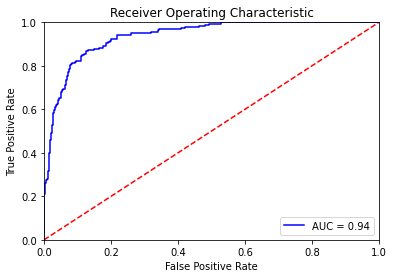

In [ ]:
evaluate_roc(probs, y_val)

In [ ]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)
# print(probs)
print(len(probs))
# Get predictions from the probabilities
threshold = 0.55
preds = np.where(probs[:, 1] > threshold, 1, 0)
print(preds)
print(len(preds))

# Number of tweets predicted non-negative
print("Number of tweets predicted rumour: ", preds.sum())
# label
# non-rumour    393
# rumour        187

580
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1
 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0
 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1
 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0
 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0
 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1
 0 0 0 0 1 0 1 0 1 0 

In [ ]:
unique, counts = np.unique(preds, return_counts=True)
dict(zip(unique, counts))

{0: 403, 1: 177}

In [ ]:
Corpus_pred_bert = Corpus_dev
print(Corpus_pred_bert.head())
# y_predicted = nb_model.predict(X_test_tfidf)
y_labels = ["non-rumour" if i==0 else "rumour" for i in preds]
# print(y_predicted,y_predicted_labels)
Corpus_pred_bert['label'] = y_labels
print(Corpus_pred_bert.head())
# Corpus_pred_bert.set_index('id',inplace=True)
dictt_bert = Corpus_pred_bert.to_dict()['label']
print(dictt_bert)
print(len(dictt_bert))

                                                                tweet                      created_at       label                                        all_replies  num_replies                                all_replies_by_time
id                                                                                                                                                                                                                                  
553588913747808256  #BREAKING Reports: 2 brothers suspected of Cha...  Fri Jan 09 16:27:36 +0000 2015      rumour  [@USATODAY :it's unfortunate that they got wha...           10  [@USATODAY :it's unfortunate that they got wha...
524949003834634240  You are not alone today #Ottawa - we are here ...  Wed Oct 22 15:42:50 +0000 2014  non-rumour  [@DistressCentreO @CFRASnow interestingly - I'...            1  [@DistressCentreO @CFRASnow interestingly - I'...
553221281181859841  Have said it before, but needs saying again: S...  Thu Jan 08 16

In [ ]:
with open("dev.baseline_bert6.json", "w") as outfile: 
    json.dump(dictt_bert, outfile)

In [ ]:
print(val_data)
print(X_val)

In [ ]:
print(dfs_dev)
print(Corpus_dev)

In [ ]:
output = Corpus_dev[preds==1]
print(len(output)) #117 tweets detected as rumour in val dataset(source tweets only)
# print(output)

list(output.sample(20).tweet)
lst = list(output.tweet)
print(len(lst))

### 3.5. Train Our Model on the Entire Training Data

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

## 4. Predictions on Test Set

### 4.1. Data Preparation

Let's revisit out test set shortly.

Before making predictions on the test set, we need to redo processing and encoding steps done on the training data. Fortunately, we have written the `preprocessing_for_bert` function to do that for us.

### 4.2. Predictions

There are about 300 non-negative tweets in our test set. Therefore, we will keep adjusting the decision threshold until we have about 300 non-negative tweets.

The threshold we will use is 0.992, meaning that tweets with a predicted probability greater than 99.2% will be predicted positive. This value is very high compared to the default 0.5 threshold.

After manually examining the test set, I find that the sentiment classification task here is even difficult for human. Therefore, a high threshold will give us safe predictions.

Now we will examine 20 random tweets from our predictions. 17 of them are correct, showing that the BERT Classifier acquires about 0.85 precision rate.

# E - Conclusion

By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, we can achieve near state-of-the-art performance, which is 10 points better than the baseline method although we only have 3,400 data points.

In addition, although BERT is very large, complicated, and have millions of parameters, we only need to fine-tune it in only 2-4 epochs. That result can be achieved because BERT was trained on the huge amount and already encode a lot of information about our language. An impresive performance achieved in a short amount of time, with a small amount of data has shown why BERT is one of the most powerful NLP models available at the moment. 